Name: Vu Le U43500182

Development environment (Colab or local): Colab

# Baseline, PCA, LDA and SVM analysis

- Task:
  - Come up with and implement a baseline for this task
    - Consider what technqiues we've covered in class might be relevant. Or come up with something all on your own.
    - Include a description of your baseline to accompany the implementation and explain why this baseline makes sense for this problem.
  - Compare the performance of your simple baseline, PCA, LDA, and SVM using the Olivetti faces dataset in different evaluation scenarions

- Evaluation scenarios:
  - Use 20% of the images for training and 80% for testing
  - Use 50% of the images for training and 50% for testing
  - Use 80% of the images for training and 20% for testing
  - Always use the first K images per person for training, and the remaining ones for testing (see data split code below)
  - Plot CMC curve and confusion matrix for each combination of scenario and method
  - If hyperparameters need to be selected, pull out a reasonable held-out set from the training set.

- Discussion:
  - If you used a held-out set, how did you choose your method of held-out set selection method? If not, why was it not necessary?
    - What effect did your choice have on your final results?
  - Is there a clear difference in performance for different approaches?
  - Is there a clear difference in performance for different train/test data splits?

## Olivetti faces dataset (AT&T Laboratories Cambridge)

As described on the original website:

"*There are ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).*"

The original dataset consisted of 92 x 112, while the version available here consists of 64x64 images.

- Classes: 40
- Samples per class: 10
- Samples total: 400
- Dimensionality: 4096 (64x64 pixels)
- Pixel values: real, between 0 and 1


In [93]:
from sklearn.datasets import fetch_olivetti_faces
from google.colab.patches import cv2_imshow
import numpy as np

from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC

# Get the dataset

In [ ]:
faces = fetch_olivetti_faces()

_, img_height, img_width = faces.images.shape

print(faces.images.shape)

: 

# Split the dataset

In [151]:
N_IDENTITIES = len(np.unique(faces.target)) # how many different individuals are in the dataset
GALLERY_SIZE = 8                            # use the first GALLERY_SIZE images per individual for training, the rest for testing

gallery_indices = []
probe_indices = []
for i in range(N_IDENTITIES):
  indices = list(np.where(faces.target == i)[0])
  gallery_indices += indices[:GALLERY_SIZE]
  probe_indices += indices[GALLERY_SIZE:]

x_train = faces.images[gallery_indices].reshape(-1, img_height*img_width) # vectorize train images
y_train = faces.target[gallery_indices]
x_test = faces.images[probe_indices].reshape(-1, img_height*img_width)    # vectorize test images
y_test = faces.target[probe_indices]

print(x_train.shape, x_test.shape)

(320, 4096) (80, 4096)


# Visualize the splits

In [102]:
def show_images(imgs, num_rows, num_cols):
  assert len(imgs) == num_rows*num_cols

  for i in range(num_rows):
    row = None
    for j in range(num_cols):
      if row is None:
        row = imgs[i*num_cols+j].reshape(img_height, img_width)*255.0
      else:
        row = np.concatenate((row, imgs[i*num_cols+j].reshape(img_height, img_width)*255.0), axis=1)
    cv2_imshow(row)

In [ ]:
# show_images(x_train, N_IDENTITIES, GALLERY_SIZE)

In [29]:
# show_images(x_test, N_IDENTITIES, 10 - GALLERY_SIZE)

# Implement your baseline

Here is the code for my baseline, along with an explanation of how it works and why it makes sense for this problem.

In [32]:
def baseline(x_train, y_train, x_test, y_test):
  nb = GaussianNB() #create Gaussian NB classifier
  nb.fit(x_train, y_train) #train the classifier
  predictions = nb.predict(x_test)  #make predictions on test data
  accuracy = accuracy_score(y_test, predictions) #evaluate accuracy of our model (compare true labels w/ predicted labels)
  print(accuracy)

  #Naive Bayes is a good baseline for this problem because of its simplicity and efficiency, making it a suitable starting point for experimentation.
  #Our task requires us to identify patterns in high-dimensional data, so Naive Bayes will provide a foundational understanding of the problem.
  #Also, Gaussian NB performs well with continuous data, which aligns with the facial features in our problem.
  #Naive Bayes serves as an adequate baseline for assessing the initial performance and will provide insight into the characteristics of our dataset.


In [31]:
baseline(x_train, y_train, x_test, y_test)

0.725


# Run the experiments

Here is the code I used to get the results below!

In [116]:
def plot_cmc_curves(classifier, x_train, y_train, x_test, y_test, num_components_range):
    for i in num_components_range:
        if classifier == 'LDA':
          model = LDA(n_components=i)
        elif classifier == 'Naive Bayes':
          model = GaussianNB()
        elif classifier == 'SVM':
          model = SVC(kernel='linear')
        elif classifier == 'PCA':
          model = PCA(n_components=i)

        model.fit(x_train, y_train)

        if hasattr(model, 'transform'):
          gallery = model.transform(x_train.reshape(-1, img_height*img_width))
          probe = model.transform(x_test.reshape(-1, img_height*img_width))
        else:
          gallery = x_train
          probe = x_test

        CMC = {}
        for j in range(len(probe)):
            genuine_dist = np.inf
            for k in range(len(gallery)):
                if y_test[j] == y_train[k]:
                    dist = np.sum((gallery[k] - probe[j]) ** 2)
                    if dist < genuine_dist:
                        genuine_dist = dist

            ids = set()
            for k in range(len(gallery)):
                if y_test[j] != y_train[k]:
                    dist = np.sum((gallery[k] - probe[j]) ** 2)
                    if dist < genuine_dist:
                        ids.add(y_train[k])

            rank = 1 + len(ids)
            if rank not in CMC:
                CMC[rank] = 1
            else:
                CMC[rank] += 1

        rank = []
        acc = []
        total = 0
        for j in range(1, len(probe) + 1):
            if j in CMC:
                total += CMC[j]
            rank.append(j)
            acc.append(100.0 * total / len(probe))

        plt.plot(rank, acc, label=str(i) + ' eigenvectors')

    plt.title(f'Cumulative Match Characteristic (CMC) Curves for {classifier}')
    plt.legend()
    plt.ylim(0, 100)
    plt.xlim(0,40)
    plt.show()

In [ ]:
classifier = "SVM" #Change this to create a CMC curve for a specified classifier (Naive Bayes, PCA, LDA, SVM)

# If classifier is PCA or LDA, range must be changed to range(1, 40)

plot_cmc_curves(classifier, x_train, y_train, x_test, y_test, range(10,101,10))

#  Uncomment this to print all classifiers
# plot_cmc_curves("Naive Bayes" x_train, y_train, x_test, y_test, range(10,101,10))
# plot_cmc_curves("PCA", x_train, y_train, x_test, y_test, range(1,40))
# plot_cmc_curves("LDA", x_train, y_train, x_test, y_test, range(1,40))
# plot_cmc_curves("SVM", x_train, y_train, x_test, y_test, range(10,101,10))


In [157]:
def plot_confusion_matrix(classifier, x_train, y_train, x_test, y_test, num_components):
  if classifier == 'LDA':
    model = LDA(n_components=num_components)
  elif classifier == 'Naive Bayes':
    model = GaussianNB()
  elif classifier == 'SVM':
    model = SVC(kernel='linear')
  elif classifier == 'PCA':
    pca = PCA(n_components=num_components)
    x_train = pca.fit_transform(x_train)
    x_test = pca.transform(x_test)
    model = GaussianNB()

  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  cm = confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(10, 8))
  sns.heatmap(cm.T, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
  plt.title(f'Confusion Matrix for {classifier}')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

In [ ]:
classifier = "SVM" #Change this to create a confusion matrix for a specified classifier (Naive Bayes, PCA, LDA, SVM)

plot_confusion_matrix(classifier, x_train, y_train, x_test, y_test, 39)

# Uncomment this to print all classifiers
# plot_confusion_matrix("Naive Bayes", x_train, y_train, x_test, y_test, 39)
# plot_confusion_matrix("PCA", x_train, y_train, x_test, y_test, 39)
# plot_confusion_matrix("LDA", x_train, y_train, x_test, y_test, 39)
# plot_confusion_matrix("SVM", x_train, y_train, x_test, y_test, 39)

# Report your results

Check these amazing plots I have below!

# Baseline (Naive Bayes)


##20-80

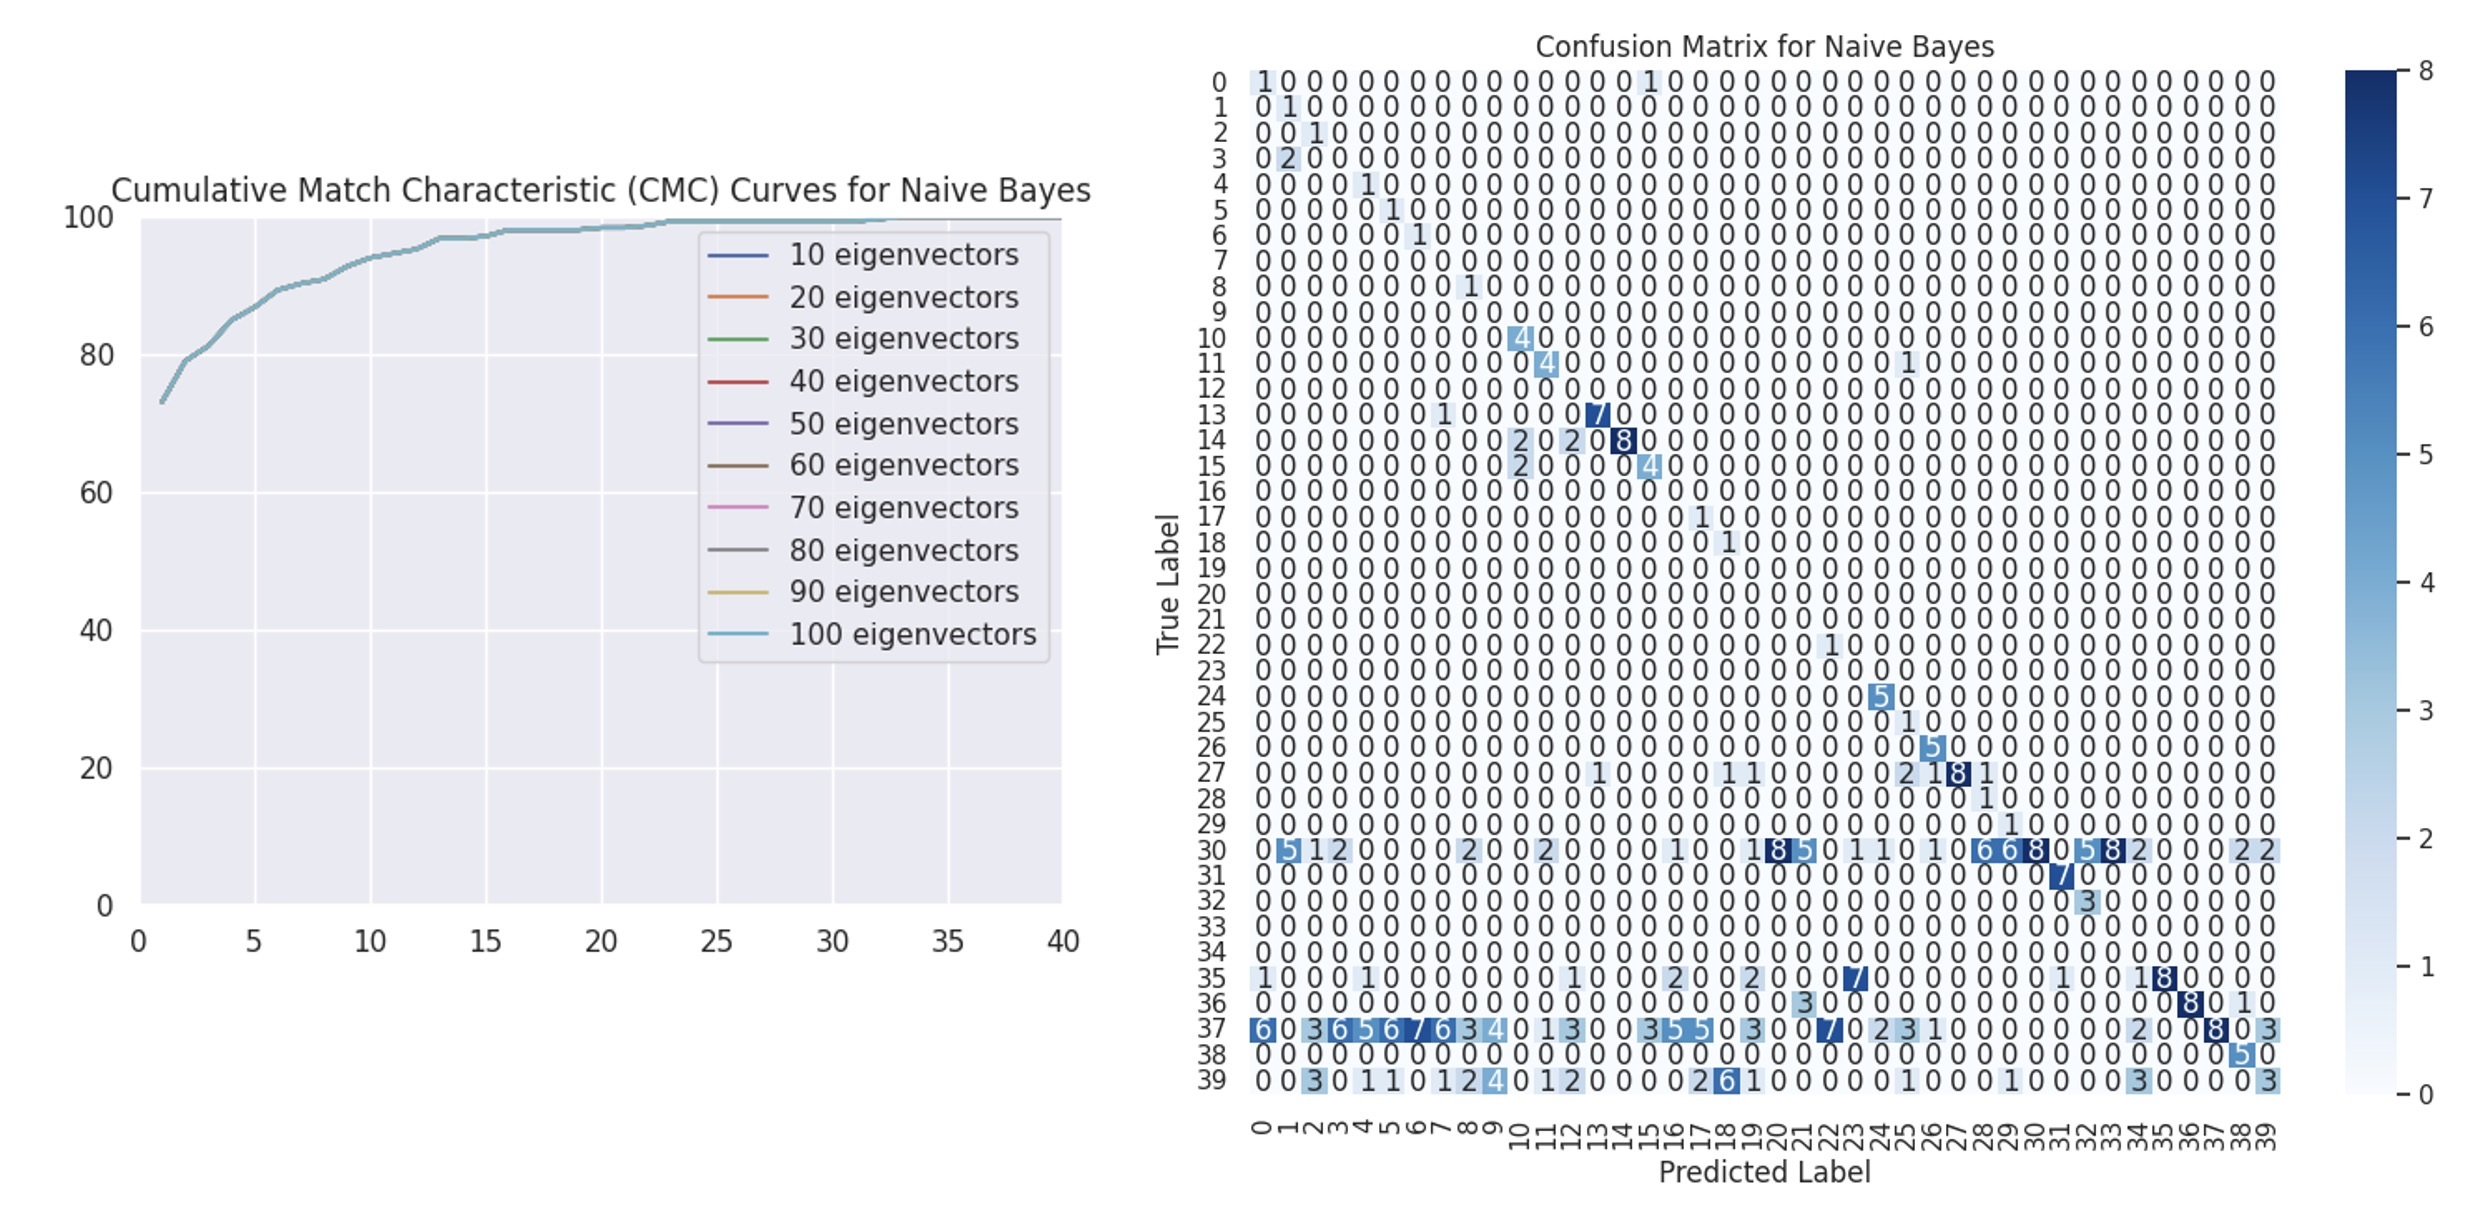


##50-50

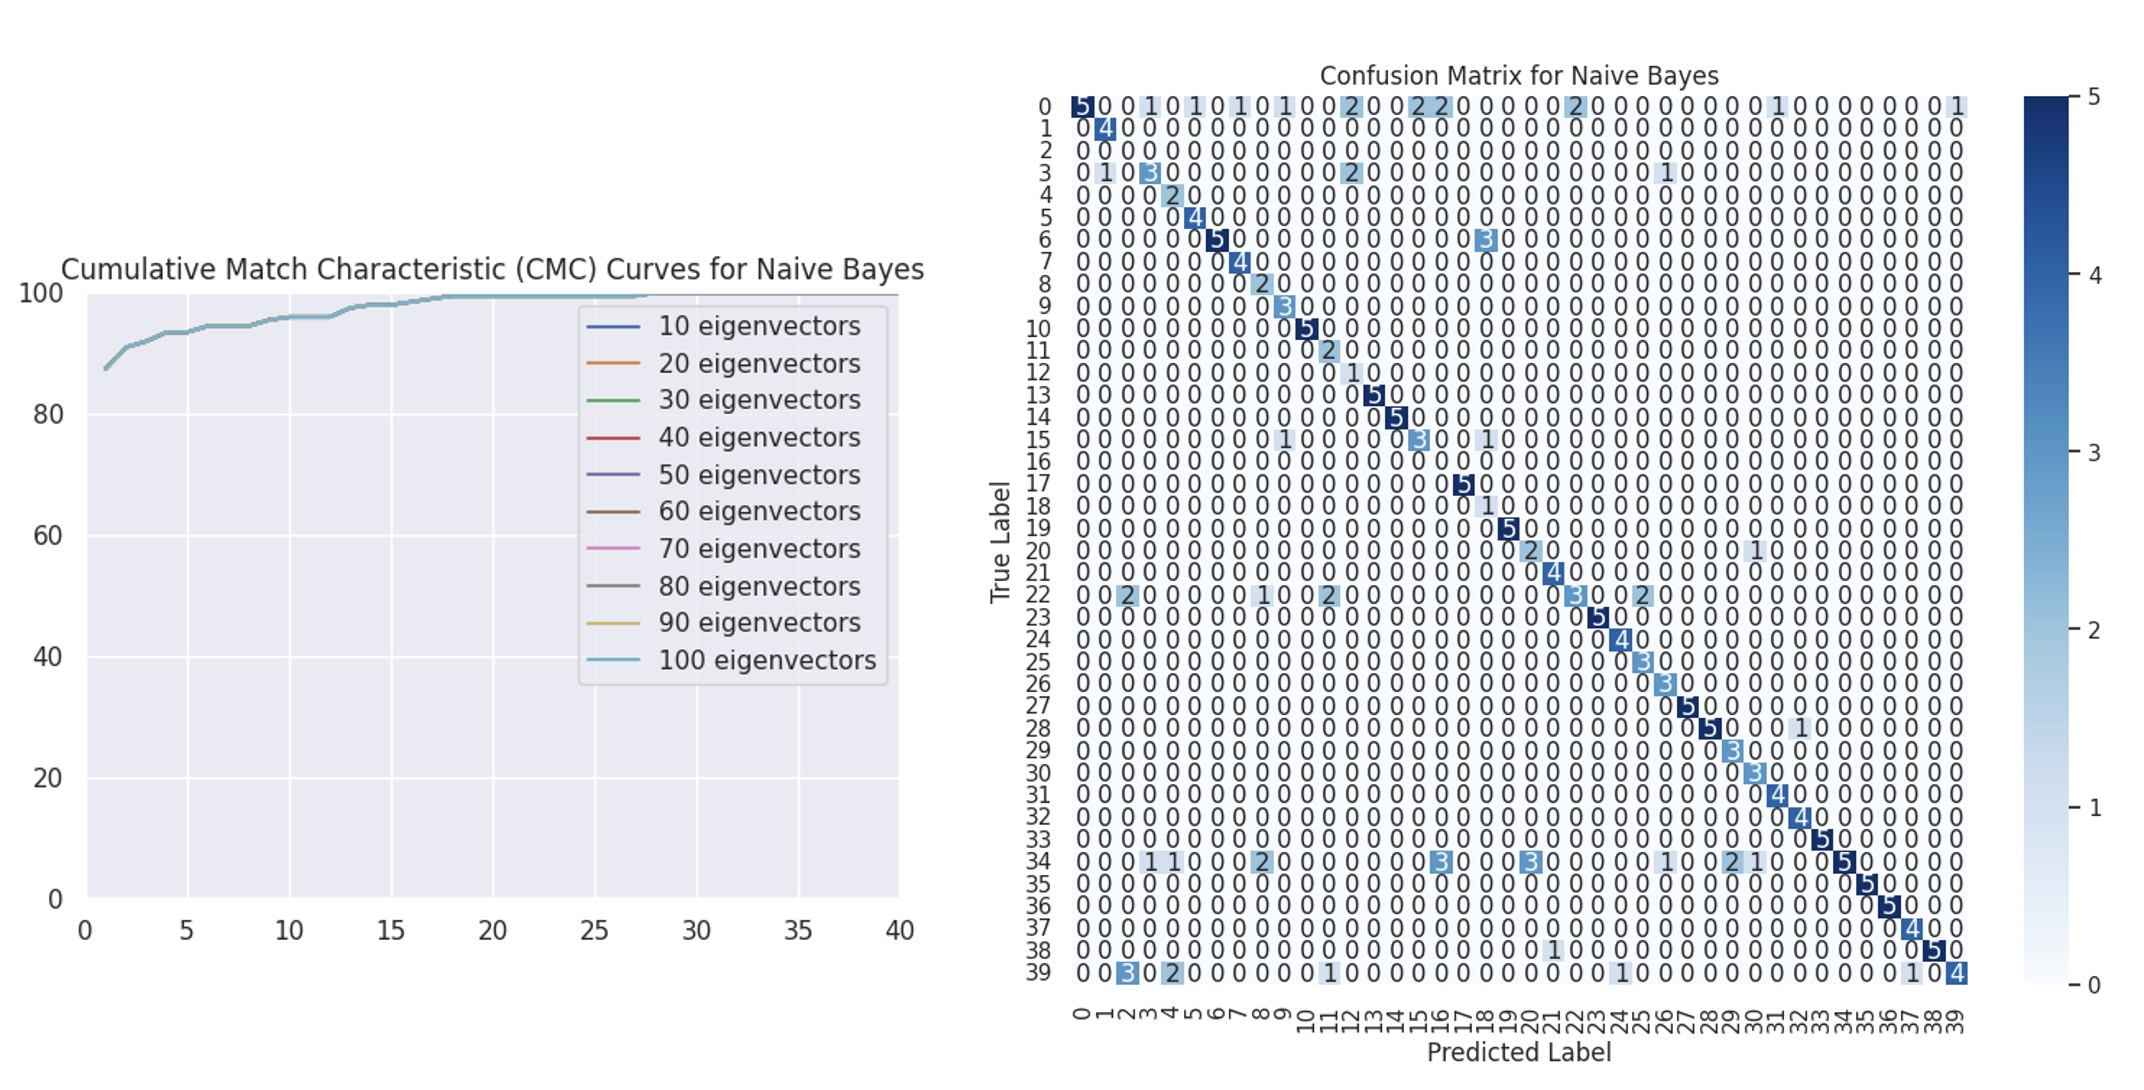

##80-20

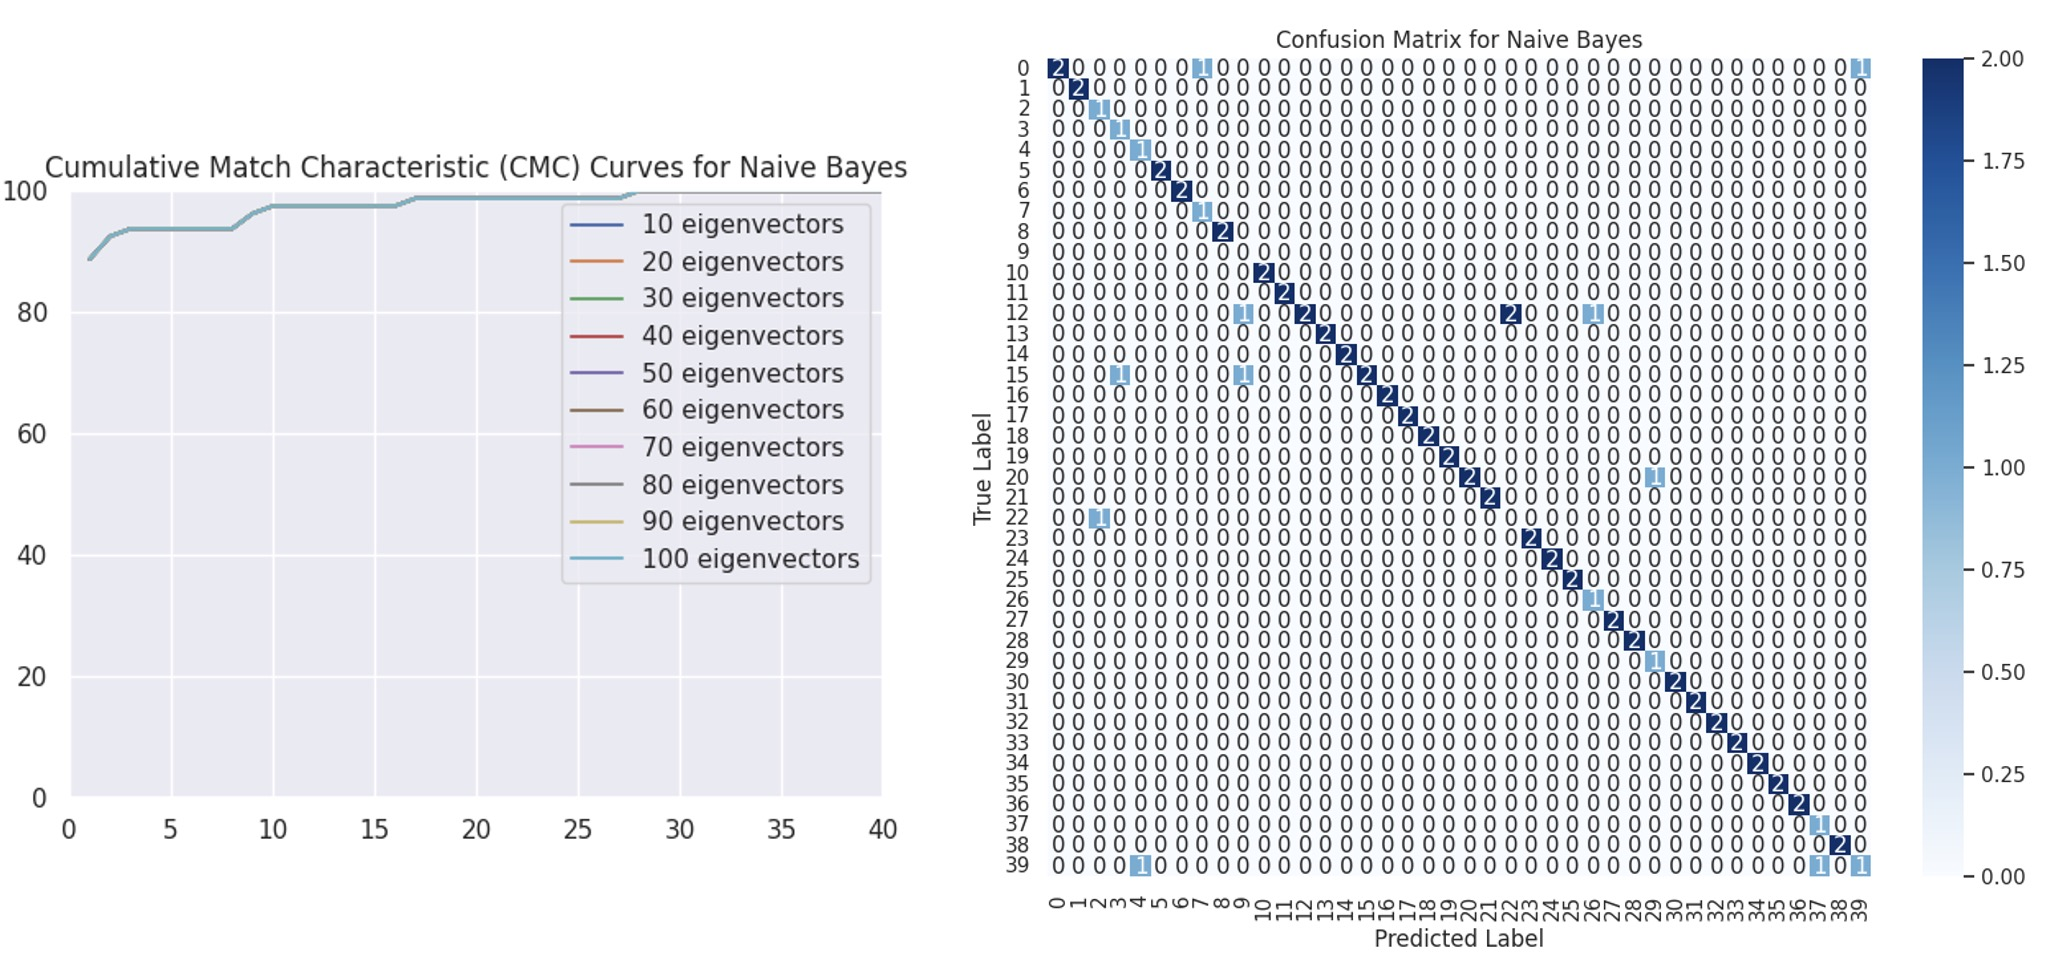

#PCA

##20-80
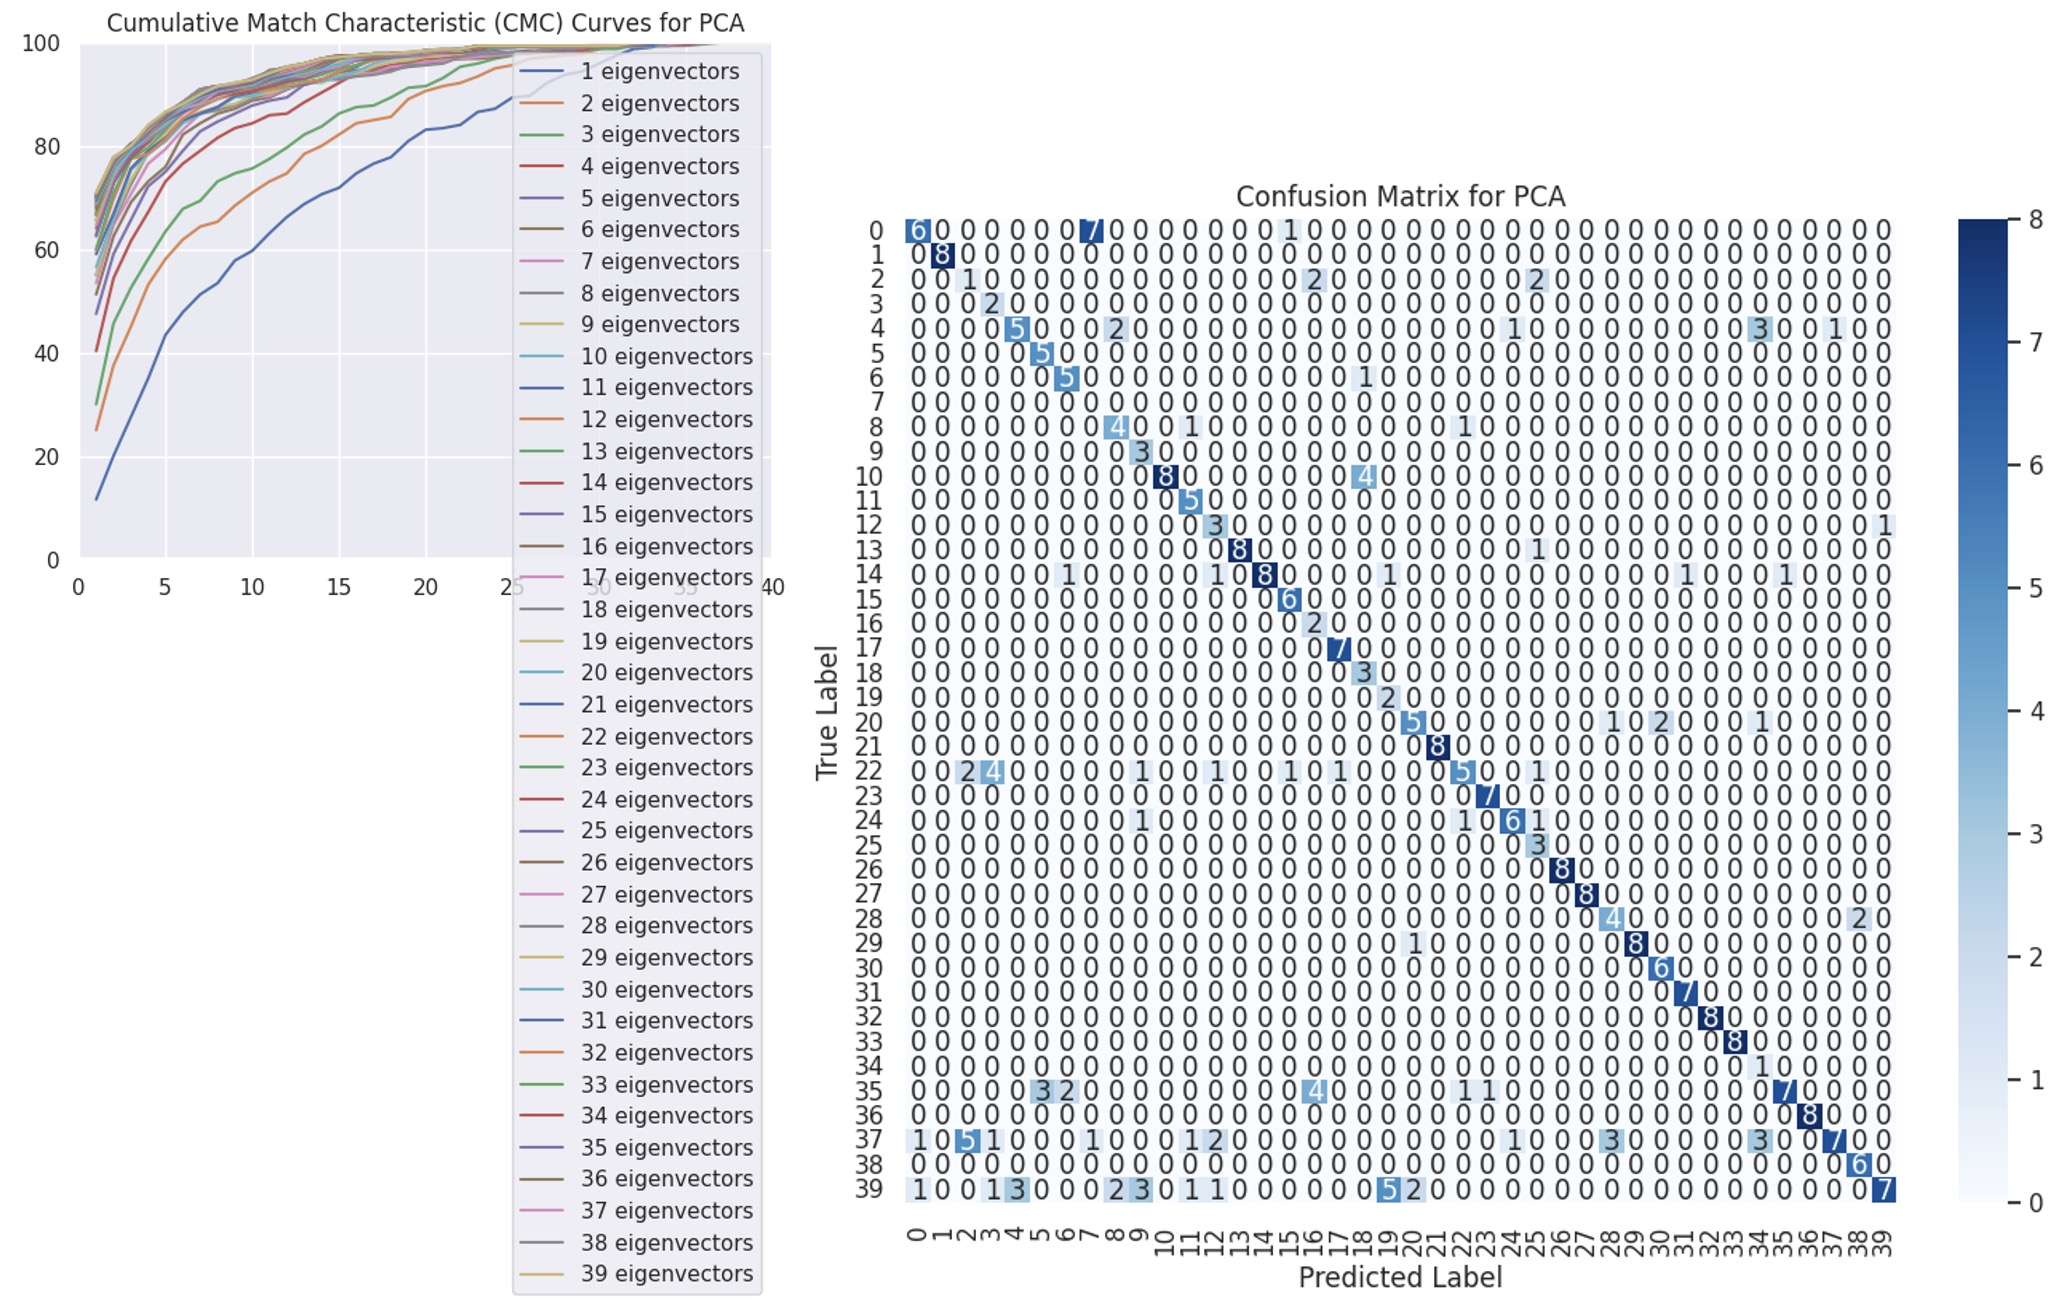

##50-50

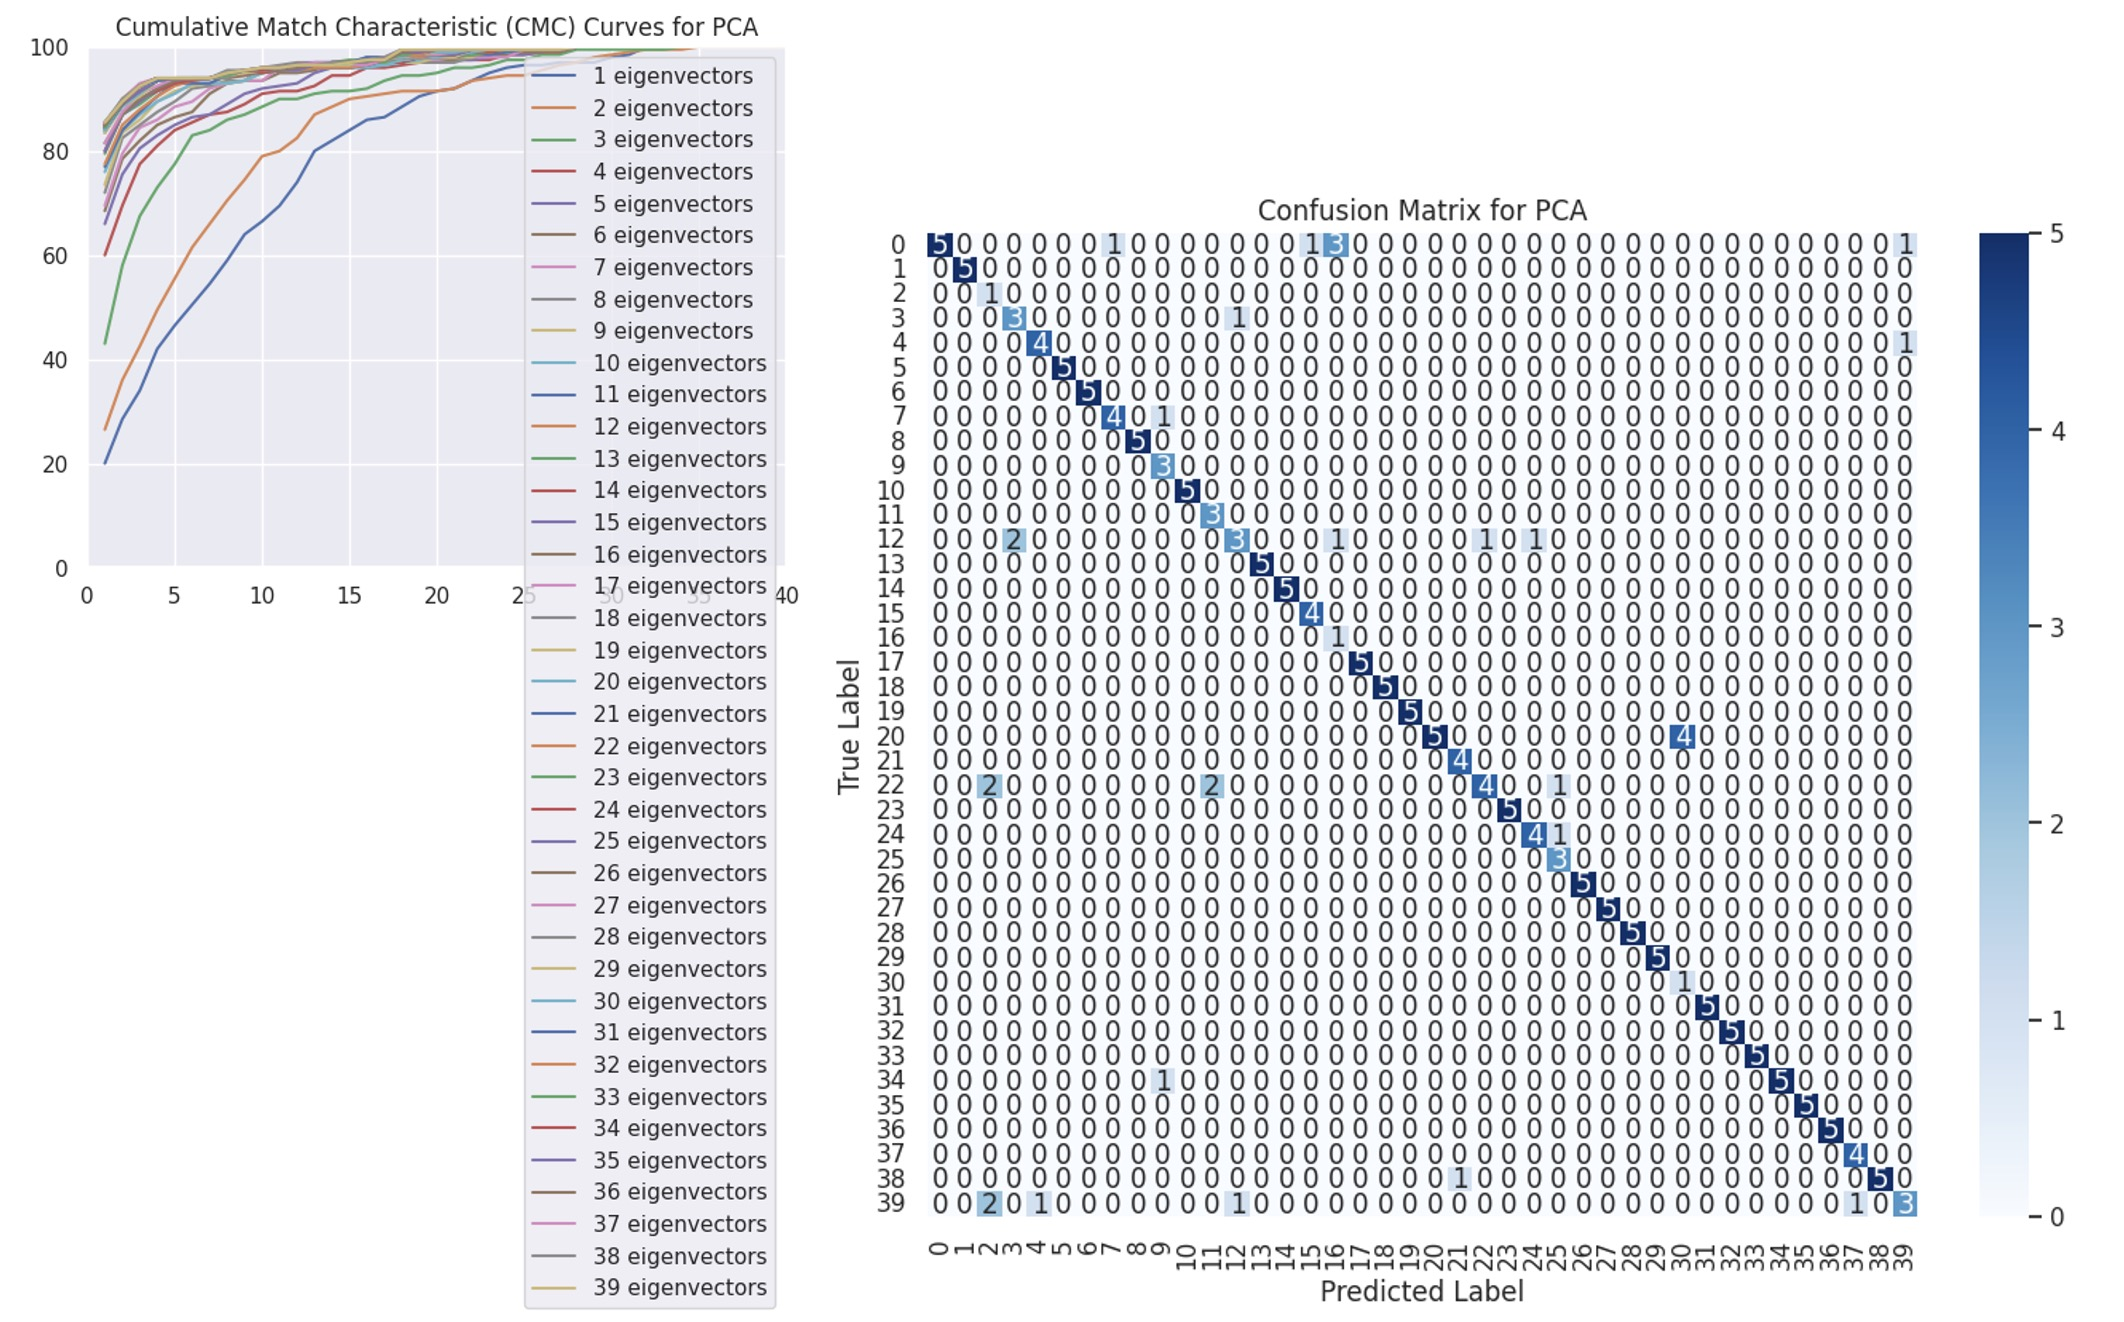

##80-20

Screenshot 2023-11-22 at 8.57.36 PM.JPG

#LDA

##20-80

Screenshot 2023-11-22 at 9.00.51 PM.JPG

##50-50

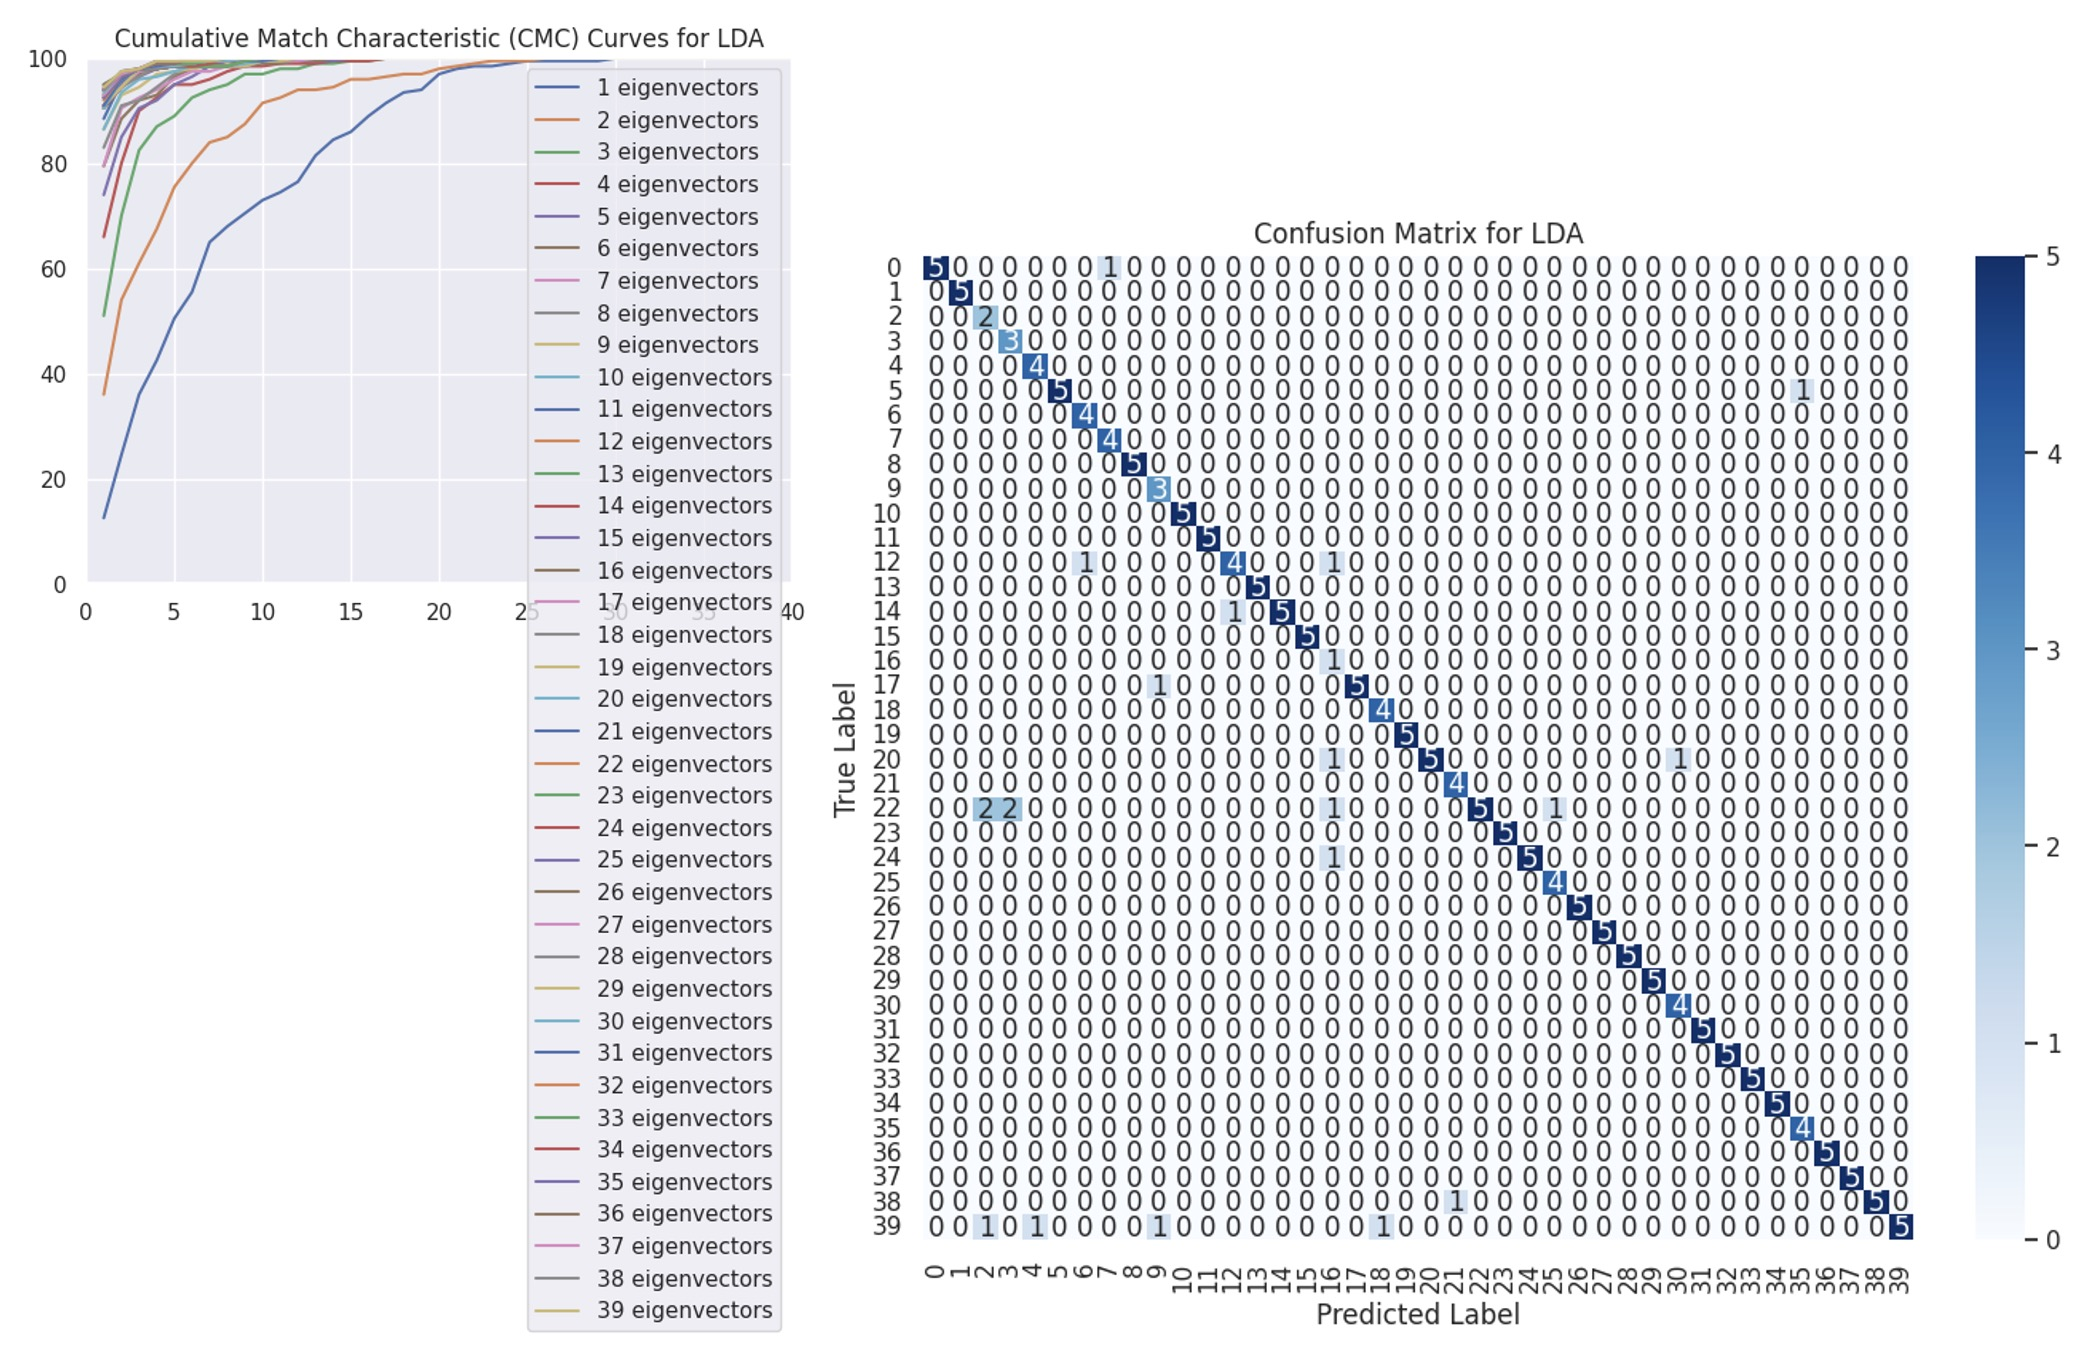

##80-20

Screenshot 2023-11-22 at 9.12.17 PM.JPG

#SVM
##20-80

Screenshot 2023-11-22 at 9.16.32 PM.JPG

##50-50

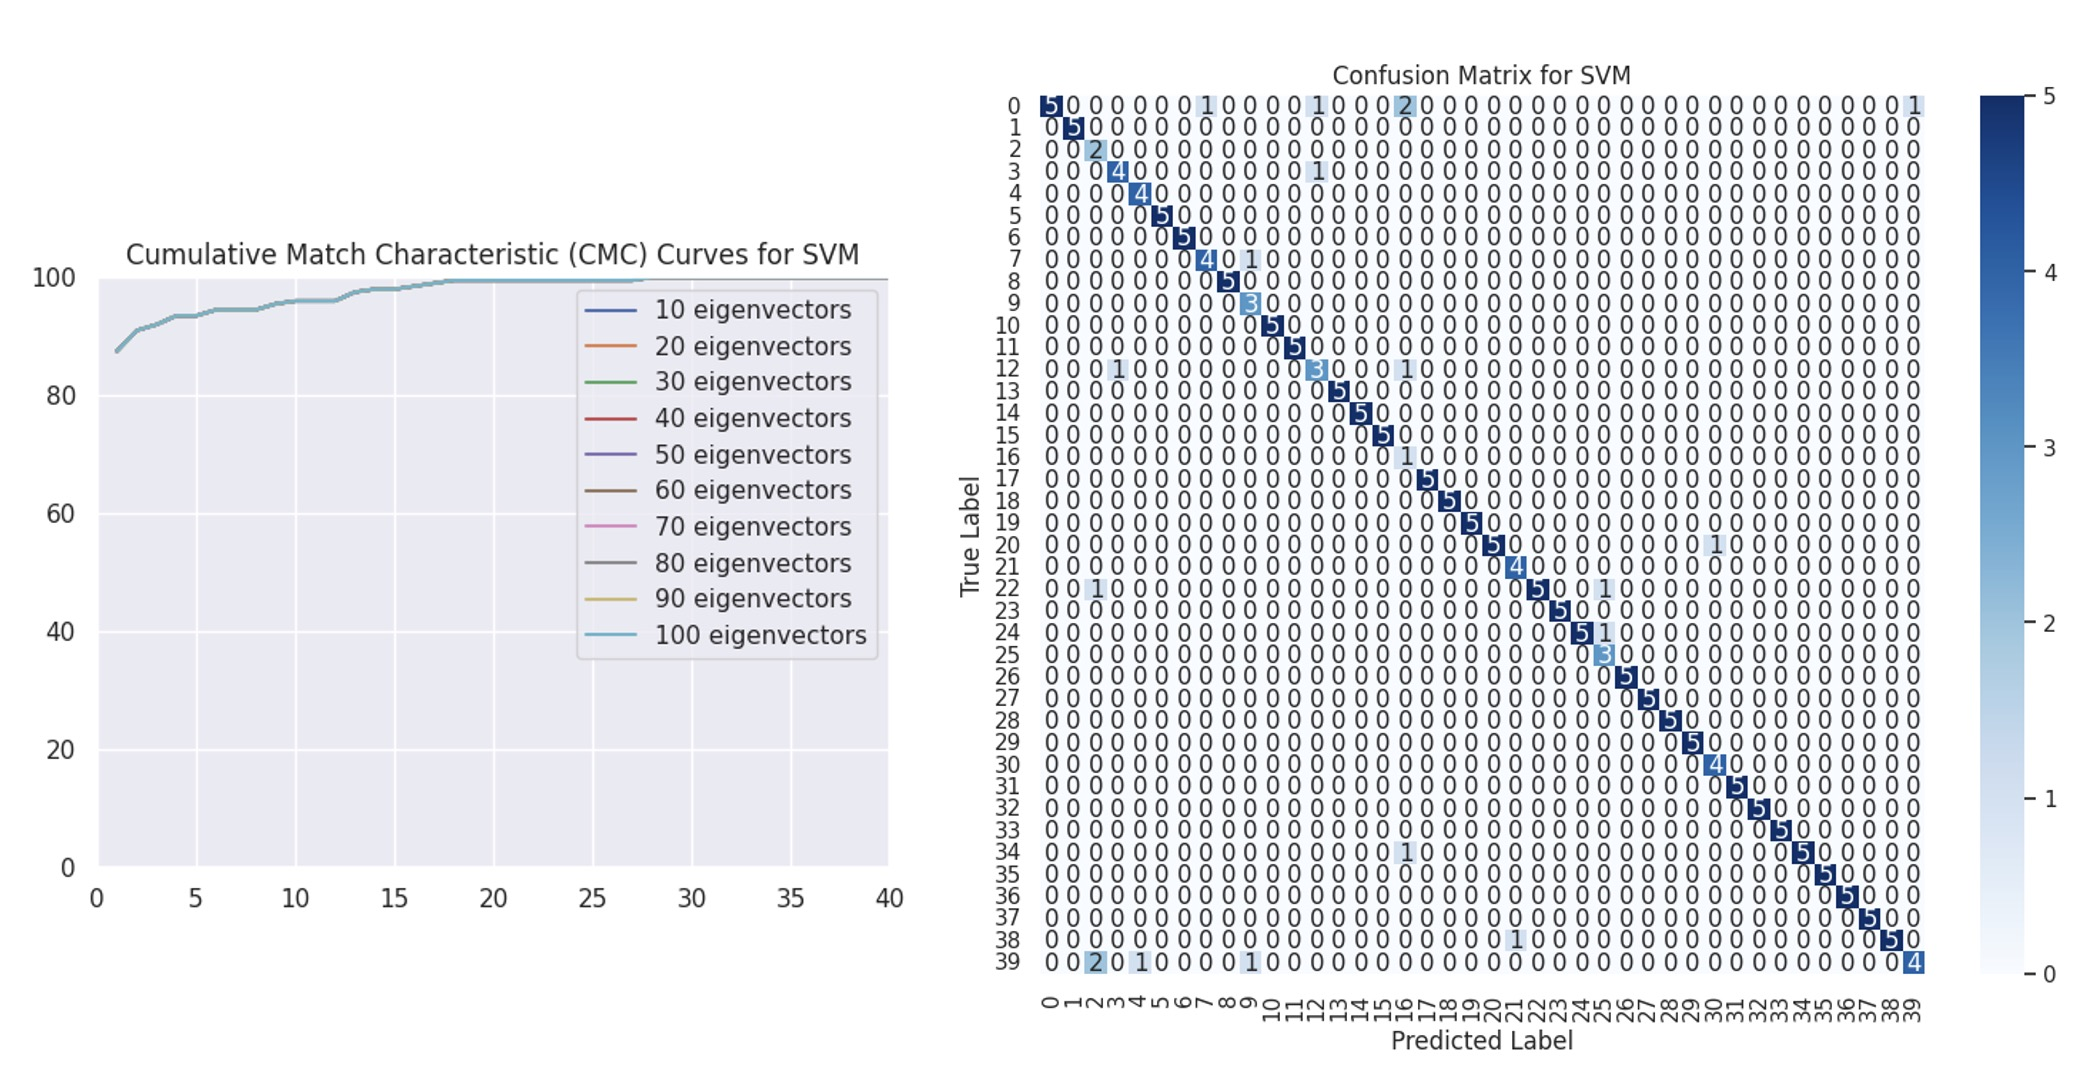

##80-20

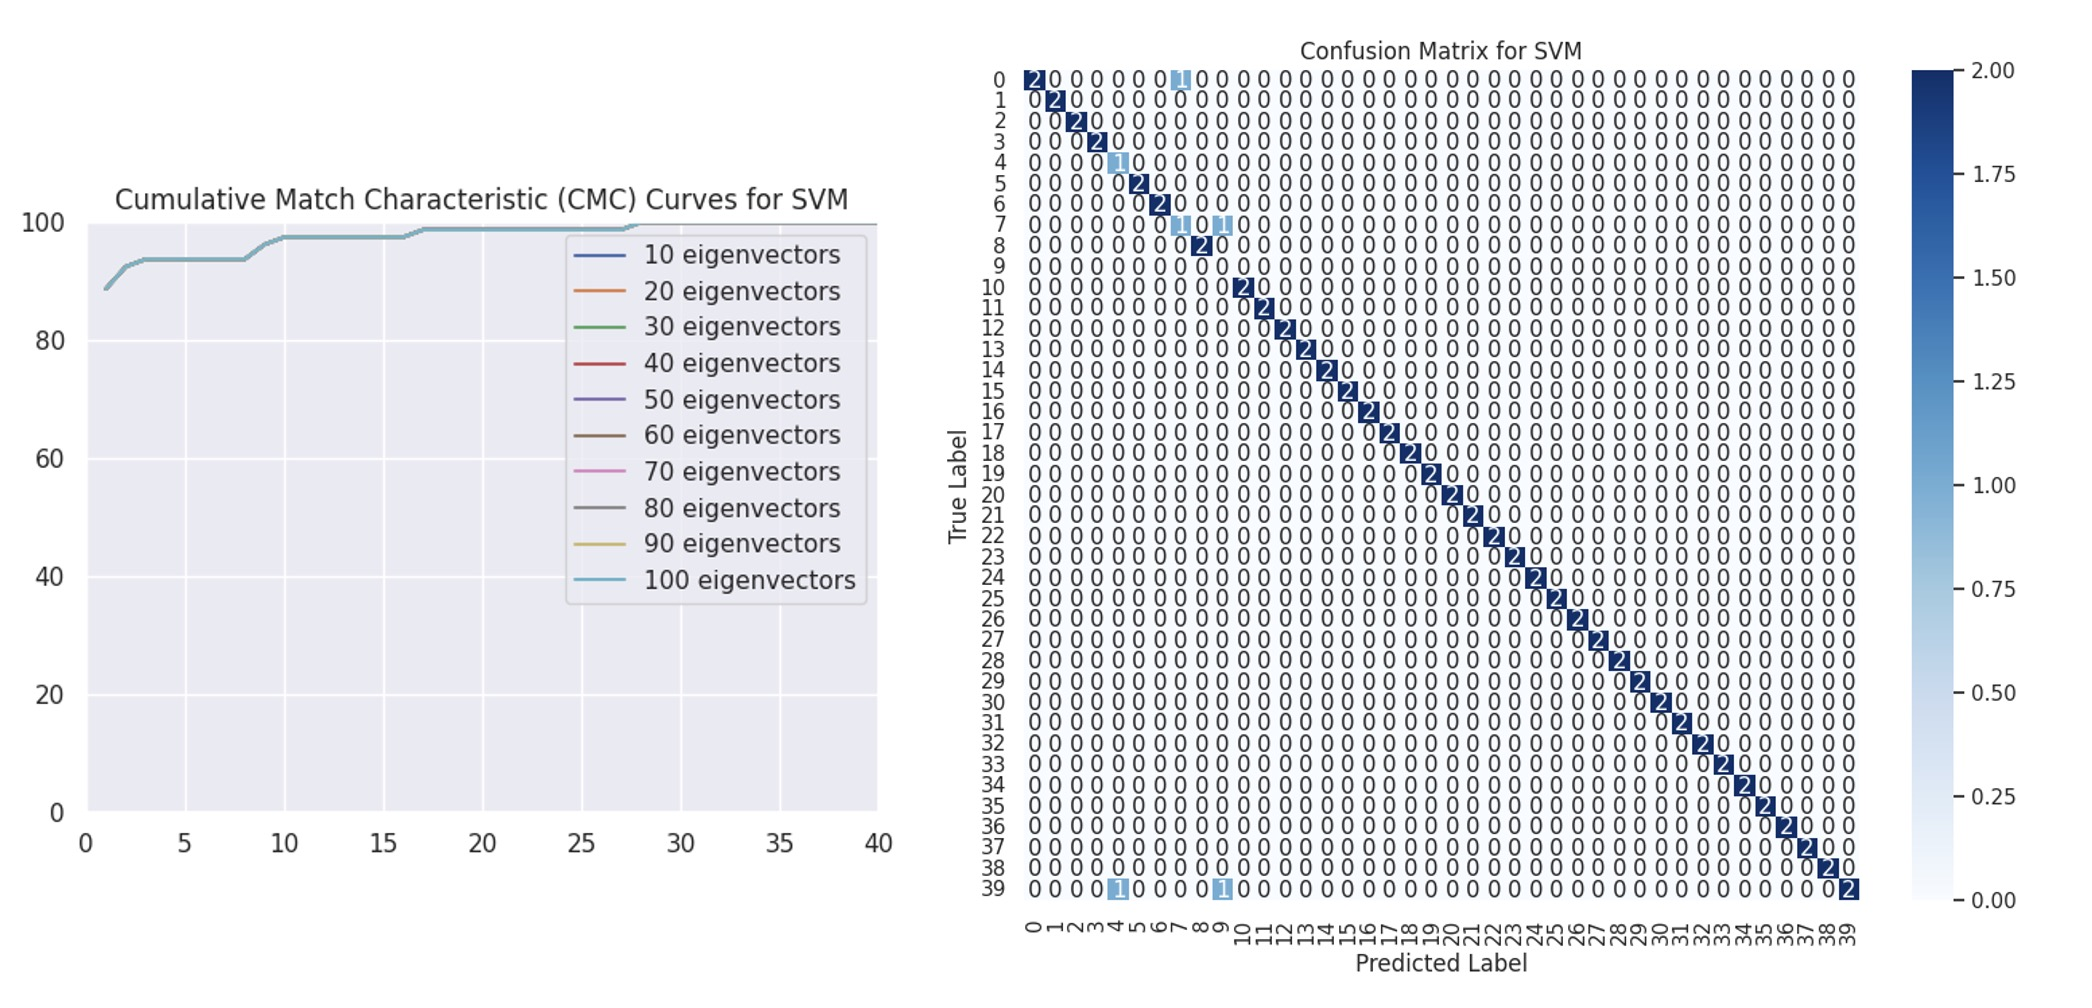

#Discussion

For my baseline, I used Naive Bayes due to its simplicity and efficiency. Naive Bayes can perform well on certain types of data, particularly when the assumption of feature independence holds. It performed reasonably well despite it being such a straightforward algorithm. However, the 20-80 data split performed quite horribly with Naive Bayes, which is why other methods must be explored in this project. Though the other approaches performed better, it served as a quick, interpretable solution to our problem.

In my code, I didn't explicitly use a held-out set for hyperparameters because it wasn’t necessary for the us to avoid overfitting to the test set. This choice did not have much of an effect on my results as each scenario performed relatively well. This is probably due to the lower complexity of our model and the relatively small sample size of our data. In practice, it is a good idea to use a separate held-out set, but for this experiment, the goal was to illustrate a basic overview for these methods under different scenarios of test data splits, which does not require us to optimize our data as much.



Yes, there was a clear difference in performance for different approaches. With the baseline implementation of Naive Bayes, I found that it performed poorly compared to other methods. From the graphs, it seems that SVM and LDA perform the best regardless of test/data splits. This is due to SVM’s ability to handle complex decision boundaries, and LDA’s focus on finding a projection that maximizes class separability. Then PCA, which performs relatively well by reducing the dimensionality, then Naive Bayes, which was a simple and computationally efficient algorithm, but does not hold well for the complex and high-dimensional feature space of face images.


Yes, there was a clear difference in performance for different train/test data splits. Across all methods, 20-80 performed the worst, then 50-50, then 80-20. From the CMC curves, models trained on a larger proportion of data displayed better initial performance. This is because models with more training data start with a better understanding of the underlying patterns in the data. Also, the models with more training data converged more quickly due to the information provided by a larger training set, enabling the models to adjust their parameters more efficiently. From the confusion matrices, we see that models trained on more data had fewer misclassifications, indicating a more robust understanding of the unique features associated with each class. When the train data was smaller, the CMC curves had lower initial performance in the CMC and more misclassifications in the confusion matrix.